In [1]:
# Incorporate point-correlation
def correlation_fun(x,input_dim,Rad):
    point_corr=0
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=tf.multiply(x[0][i,j],x[0][i,tf.mod(j+Rad,input_dim)])
            point_corr=tf.add(point_corr_temp1,point_corr)
    
    for i in range(input_dim):
        for j in range(input_dim):           
            point_corr_temp2=tf.multiply(x[0][i,j],x[0][tf.mod(i+Rad,input_dim),j])
            point_corr=tf.add(point_corr_temp2,point_corr)
    return (point_corr+2*input_dim**2)/4.

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

    return fig

def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="SAME"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)       
    
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu),stddev=1.0)
    return mu + tf.exp(log_var / 2) * eps

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
#     features_mean,features_var =tf.nn.moments(features,axes=[0])    
    features_mean = tf.reduce_mean(features,0)
    features = (features-features_mean)/1
    gram = backend.dot(features, backend.transpose(features))  
    return gram

def style_loss(style, combination):
    loss_temp=0.
    channels = 3
    size = height * width
    
    for i in range(mb_size):
        C = gram_matrix(combination[i])
        S = gram_matrix(style[i])
        loss_temp = tf.add(loss_temp,backend.sum(backend.square(S - C))/(4. * (channels ** 2) * (size ** 2)))*1e-7
    
    return loss_temp


def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/4, height/4, 1]), 
                                                  deconv1_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, height/2, conv1_features]),deconv1_bias))
#     h2 = build_unpool(h2_conv, [1, 2, 2, 1])
    
    h3 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h2,[mb_size, width/2, height/2, conv1_features]), 
                                                  deconv2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, height/1, conv2_features]),deconv2_bias))
    
    h4 = (tf.add(tf.nn.conv2d_transpose(tf.reshape(h3,[mb_size, width/1, height/1, conv2_features]), 
                                                  deconv3_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, height/1, conv3_features]),deconv3_bias))
    
    prob = tf.nn.tanh(h4)
    return prob

def Q(X):    
#     h = tf.nn.relu(tf.matmul(tf.reshape(X,[mb_size,X_dim]), Q_W1) + Q_b1)
#     z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
#     z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
#     return z_mu, z_logvar


    h1 = tf.nn.relu(tf.add(conv2d(tf.reshape(X,[mb_size, width/1, height/1, 1]),
                                  conv1_weight, stride=2, padding='SAME'),conv1_bias))
    
    h2 = tf.nn.relu(tf.add(conv2d(tf.reshape(h1,[mb_size, width/2, height/2, 32]),
                                  conv2_weight, stride=2, padding='SAME'),conv2_bias))
    
    
    h3 = tf.nn.relu(tf.matmul(tf.reshape(h2,[mb_size,width/4*height/4*64]), Q_W1) + Q_b1)
    
    z_mu = tf.matmul(h3, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h3, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

In [3]:
######## loading input data ########
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
import h5py
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
# from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data


images = np.array(sio.loadmat('alloy_mat/sandstone_v2_test.mat')['Data'],dtype='float32')
images_L = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young_test.mat')['L'],dtype='float32')
images=images[0:240]

mb_size = 20
X_dim = images.shape[1]
width = 128
height = 128
h_dim = width/4*height/4
z_dim = 128/4


conv1_features=64
conv2_features=32
conv3_features=1
c = 0

num_channels_1=1
num_channels_2=64
num_channels_3=32
lr = 1e-3


# images_style = np.array(sio.loadmat('WB_raw2.mat')['WB'],dtype='float32')

style_array = np.zeros([len(images),height,width,3])
style_array[:,:,:,0]=(images.reshape(len(images),height,width))*255
style_array[:,:,:,1]=(images.reshape(len(images),height,width))*255
style_array[:,:,:,2]=(images.reshape(len(images),height,width))*255
print(style_array.shape)


Using TensorFlow backend.


(240, 128, 128, 3)


In [4]:
######## weights & bias loaading ########
f = h5py.File('weights_VGG/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','r')
ks = f.keys()

vgg16_weights=[]
vgg16_bias=[]
for i in range(18):
    if (len(f[ks[i]].values())) != 0:        
        vgg16_weights.append(f[ks[i]].values()[0][:])
        vgg16_bias.append(f[ks[i]].values()[1][:])
    else:
        continue

W_conv1 = (tf.constant(vgg16_weights[0]))
W_conv2 = (tf.constant(vgg16_weights[1]))
W_conv3 = (tf.constant(vgg16_weights[2]))
W_conv4 = (tf.constant(vgg16_weights[3]))
W_conv5 = (tf.constant(vgg16_weights[4]))
W_conv6 = (tf.constant(vgg16_weights[5]))
W_conv7 = (tf.constant(vgg16_weights[6]))
W_conv8 = (tf.constant(vgg16_weights[7]))
W_conv9 = (tf.constant(vgg16_weights[8]))
W_conv10= (tf.constant(vgg16_weights[9]))
W_conv11= (tf.constant(vgg16_weights[10]))
W_conv12= (tf.constant(vgg16_weights[11]))
W_conv13= (tf.constant(vgg16_weights[12]))

b_conv1 = tf.reshape(tf.constant(vgg16_bias[0]),[-1])
b_conv2 = tf.reshape(tf.constant(vgg16_bias[1]),[-1])
b_conv3 = tf.reshape(tf.constant(vgg16_bias[2]),[-1])
b_conv4 = tf.reshape(tf.constant(vgg16_bias[3]),[-1])
b_conv5 = tf.reshape(tf.constant(vgg16_bias[4]),[-1])
b_conv6 = tf.reshape(tf.constant(vgg16_bias[5]),[-1])
b_conv7 = tf.reshape(tf.constant(vgg16_bias[6]),[-1])
b_conv8 = tf.reshape(tf.constant(vgg16_bias[7]),[-1])
b_conv9 = tf.reshape(tf.constant(vgg16_bias[8]),[-1])
b_conv10 = tf.reshape(tf.constant(vgg16_bias[9]),[-1])
b_conv11 = tf.reshape(tf.constant(vgg16_bias[10]),[-1])
b_conv12 = tf.reshape(tf.constant(vgg16_bias[11]),[-1])
b_conv13 = tf.reshape(tf.constant(vgg16_bias[12]),[-1])

In [5]:
# =============================== Q(z|X) ======================================

z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, height, num_channels_1)
X = tf.placeholder(tf.float32, shape=x_input_shape)

conv1_weight = tf.Variable(tf.truncated_normal([4, 4, 1, 32],
                                               stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([32], dtype=tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, 32,64],
                                               stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([64], dtype=tf.float32))


# Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
# Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W1 = tf.Variable(xavier_init([X_dim*64/4/4, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

In [6]:
# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

deconv1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, num_channels_1],
                                               stddev=0.1, dtype=tf.float32))
deconv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

deconv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features,num_channels_2],
                                               stddev=0.1, dtype=tf.float32))
deconv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

deconv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, num_channels_3],
                                               stddev=0.1, dtype=tf.float32))
deconv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))



In [7]:
# =============================== Middel Results ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)


In [8]:
######## style transfer ########
combination_image_temp=tf.reshape(X_samples,[mb_size, height, width, 1])*255
combination_image = tf.concat([combination_image_temp, combination_image_temp,combination_image_temp], 3)

style_image = tf.placeholder(tf.float32, shape=(mb_size,height,width,3))

In [9]:
######### block 1 ########
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.relu(conv_out1)

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2)
conv_out2 = tf.nn.relu(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
conv_out3 = tf.nn.bias_add(conv_out3, b_conv3)
conv_out3 = tf.nn.relu(conv_out3)

conv_out4 = conv2d(conv_out3, W_conv4, stride=1, padding='SAME')
conv_out4 = tf.nn.bias_add(conv_out4, b_conv4)
conv_out4 = tf.nn.relu(conv_out4)
conv_out4 = max_pool(conv_out4, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5 = conv2d(conv_out4, W_conv5, stride=1, padding='SAME')
conv_out5 = tf.nn.bias_add(conv_out5, b_conv5)
conv_out5 = tf.nn.relu(conv_out5)

conv_out6 = conv2d(conv_out5, W_conv6, stride=1, padding='SAME')
conv_out6 = tf.nn.bias_add(conv_out6, b_conv6)
conv_out6 = tf.nn.relu(conv_out6)

conv_out7 = conv2d(conv_out6, W_conv7, stride=1, padding='SAME')
conv_out7 = tf.nn.bias_add(conv_out7, b_conv7)
conv_out7 = tf.nn.relu(conv_out7)
conv_out7 = max_pool(conv_out7, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8 = conv2d(conv_out7, W_conv8, stride=1, padding='SAME')
conv_out8 = tf.nn.bias_add(conv_out8, b_conv8)
conv_out8 = tf.nn.relu(conv_out8)

conv_out9 = conv2d(conv_out8, W_conv9, stride=1, padding='SAME')
conv_out9 = tf.nn.bias_add(conv_out9, b_conv9)
conv_out9 = tf.nn.relu(conv_out9)

conv_out10= conv2d(conv_out9, W_conv10, stride=1, padding='SAME')
conv_out10= tf.nn.bias_add(conv_out10, b_conv10)
conv_out10= tf.nn.relu(conv_out10)
conv_out10 = max_pool(conv_out10, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11= conv2d(conv_out10, W_conv11, stride=1, padding='SAME')
conv_out11= tf.nn.bias_add(conv_out11, b_conv11)
conv_out11= tf.nn.relu(conv_out11)

conv_out12= conv2d(conv_out11, W_conv12, stride=1, padding='SAME')
conv_out12= tf.nn.bias_add(conv_out12, b_conv12)
conv_out12= tf.nn.relu(conv_out12)

conv_out13= conv2d(conv_out12, W_conv13, stride=1, padding='SAME')
conv_out13= tf.nn.bias_add(conv_out13, b_conv12)
conv_out13= tf.nn.relu(conv_out13)

In [10]:
######### block 1 ########
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.relu(conv_out1_S)

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2)
conv_out2_S = tf.nn.relu(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
conv_out3_S = tf.nn.bias_add(conv_out3_S, b_conv3)
conv_out3_S = tf.nn.relu(conv_out3_S)

conv_out4_S = conv2d(conv_out3_S, W_conv4, stride=1, padding='SAME')
conv_out4_S = tf.nn.bias_add(conv_out4_S, b_conv4)
conv_out4_S = tf.nn.relu(conv_out4_S)
conv_out4_S = max_pool(conv_out4_S, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5_S = conv2d(conv_out4_S, W_conv5, stride=1, padding='SAME')
conv_out5_S = tf.nn.bias_add(conv_out5_S, b_conv5)
conv_out5_S = tf.nn.relu(conv_out5_S)

conv_out6_S = conv2d(conv_out5_S, W_conv6, stride=1, padding='SAME')
conv_out6_S = tf.nn.bias_add(conv_out6_S, b_conv6)
conv_out6_S = tf.nn.relu(conv_out6_S)

conv_out7_S = conv2d(conv_out6_S, W_conv7, stride=1, padding='SAME')
conv_out7_S = tf.nn.bias_add(conv_out7_S, b_conv7)
conv_out7_S = tf.nn.relu(conv_out7_S)
conv_out7_S = max_pool(conv_out7_S, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8_S = conv2d(conv_out7_S, W_conv8, stride=1, padding='SAME')
conv_out8_S = tf.nn.bias_add(conv_out8_S, b_conv8)
conv_out8_S = tf.nn.relu(conv_out8_S)

conv_out9_S = conv2d(conv_out8_S, W_conv9, stride=1, padding='SAME')
conv_out9_S = tf.nn.bias_add(conv_out9_S, b_conv9)
conv_out9_S = tf.nn.relu(conv_out9_S)

conv_out10_S= conv2d(conv_out9_S, W_conv10, stride=1, padding='SAME')
conv_out10_S= tf.nn.bias_add(conv_out10_S, b_conv10)
conv_out10_S= tf.nn.relu(conv_out10_S)
conv_out10_S= max_pool(conv_out10_S, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11_S= conv2d(conv_out10_S, W_conv11, stride=1, padding='SAME')
conv_out11_S= tf.nn.bias_add(conv_out11_S, b_conv11)
conv_out11_S= tf.nn.relu(conv_out11_S)

conv_out12_S= conv2d(conv_out11_S, W_conv12, stride=1, padding='SAME')
conv_out12_S= tf.nn.bias_add(conv_out12_S, b_conv12)
conv_out12_S= tf.nn.relu(conv_out12_S)

conv_out13_S= conv2d(conv_out12_S, W_conv13, stride=1, padding='SAME')
conv_out13_S= tf.nn.bias_add(conv_out13_S, b_conv13)
conv_out13_S= tf.nn.relu(conv_out13_S)

In [11]:
# =============================== latent to Young's Module ====================================
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with linear activation
    out_layer = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([z_dim, z_dim/4])),
    'h2': tf.Variable(tf.random_normal([z_dim/4, 1])),
}

biases = {
    'b1': tf.Variable(tf.random_normal([z_dim/4])),
    'b2': tf.Variable(tf.random_normal([1])),
}

label = tf.placeholder(tf.float32, shape=[None, 1])
pred = multilayer_perceptron(z_sample, weights, biases)

In [12]:
# =============================== Cost ====================================

# Style transfer
sl1 = style_loss(conv_out2_S,conv_out2)
sl2 = style_loss(conv_out4_S,conv_out4)
sl3 = style_loss(conv_out7_S,conv_out7)
sl4 = style_loss(conv_out10_S,conv_out10)
sl = sl1 + sl2 + sl3 + sl4

# Young's modulus cost
Young_cost = tf.reduce_mean(tf.square(pred - label))

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/4
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss + Young_cost + sl)

In [19]:
import random
solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()
for it in range(100000):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    Y_L = images_L[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E, Young_E, sl_E = sess.run([solver, vae_loss, recon_loss, kl_loss, Young_cost, sl], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              label:Y_L.reshape(mb_size,1),
                                                              style_image: style_array_input.reshape(mb_size,128,128,3),
                                                              z: np.random.randn(mb_size, z_dim)})

    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('Young_E:{}'.format(Young_E))
        print('sl_E:{}'.format(sl_E))
        
        print()


Iter: 0
Loss: 2172.66357422
recon_E:809.638061523
kl_E:1.20924675465
Young_E:83.5508041382
sl_E:1278.26538086
()
Iter: 200
Loss: 683.297973633
recon_E:455.490112305
kl_E:33.1247329712
Young_E:1.95364367962
sl_E:192.729476929
()
Iter: 400
Loss: 950.689086914
recon_E:443.225158691
kl_E:37.7582588196
Young_E:2.57230901718
sl_E:467.133331299
()
Iter: 600
Loss: 752.253540039
recon_E:441.847167969
kl_E:40.2013206482
Young_E:1.67369735241
sl_E:268.531311035
()
Iter: 800
Loss: 1265.84155273
recon_E:398.249145508
kl_E:40.279964447
Young_E:2.84914398193
sl_E:824.463317871
()
Iter: 1000
Loss: 642.273193359
recon_E:388.796813965
kl_E:39.8274040222
Young_E:2.04741883278
sl_E:211.601547241
()
Iter: 1200
Loss: 740.964233398
recon_E:397.300231934
kl_E:38.4724960327
Young_E:2.25344944
sl_E:302.938049316
()
Iter: 1400
Loss: 1024.22009277
recon_E:363.539337158
kl_E:42.9435577393
Young_E:2.96235775948
sl_E:614.774841309
()
Iter: 1600
Loss: 454.886016846
recon_E:352.03503418
kl_E:46.9839820862
Young_E:1.21

KeyboardInterrupt: 

In [135]:
save_path = saver.save(sess, "/tmp/model.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

for it in range(100000):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    Y_L = images_L[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E, Young_E, sl_E = sess.run([solver, vae_loss, recon_loss, kl_loss, Young_cost, sl], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              label:Y_L.reshape(mb_size,1),
                                                              style_image: style_array_input.reshape(mb_size,128,128,3),
                                                              z: np.random.randn(mb_size, z_dim)})

    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('Young_E:{}'.format(Young_E))
        print('sl_E:{}'.format(sl_E))
        
        print()

Iter: 0
Loss: 368.5078125
recon_E:121.163703918
kl_E:71.8992919922
Young_E:0.0132730184123
sl_E:175.431549072
()


KeyboardInterrupt: 

In [82]:
style_array_input = style_array[0:20]*1.0
_, S2, S4, S7, S10 = sess.run([solver, conv_out2_S,conv_out4_S,conv_out7_S,conv_out10_S], 
                                                feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                          label:Y_L.reshape(mb_size,1),
                                                          style_image: style_array_input.reshape(mb_size,128,128,3),
                                                          z: np.random.randn(mb_size, z_dim)})

In [84]:
S2.shape

(20, 64, 64, 64)

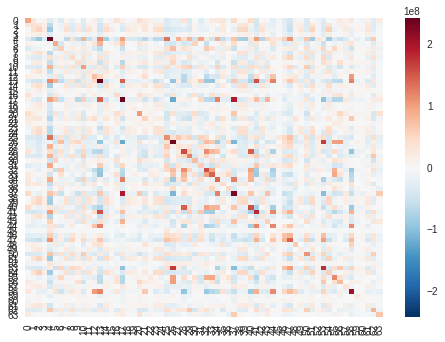

In [120]:
import seaborn as sns
S2_1=sess.run(gram_matrix(S2[1,:,:,:]))
sns.heatmap(S2_1)

(array([   30.,   138.,  1202.,  2059.,   504.,    98.,    41.,    14.,
            5.,     5.]),
 array([ -1.21304024e+08,  -8.49199112e+07,  -4.85357984e+07,
         -1.21516856e+07,   2.42324272e+07,   6.06165400e+07,
          9.70006528e+07,   1.33384766e+08,   1.69768878e+08,
          2.06152991e+08,   2.42537104e+08]),
 <a list of 10 Patch objects>)

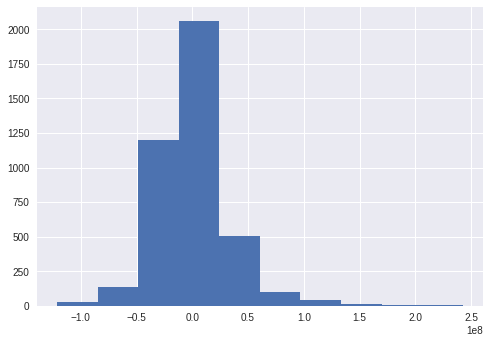

In [122]:
plt.hist(S2_1.reshape(-1))

In [119]:
S2_1=sess.run(gram_matrix(S2[1,:,:,:]))
S2_2=sess.run(gram_matrix(S2[2,:,:,:]))
# (4. * (channels ** 2) * (size ** 2))
np.sum(np.square(S2_1-S2_2))/(4. * (3 ** 2) * (128 ** 4))*1e-7

18.417130666666665

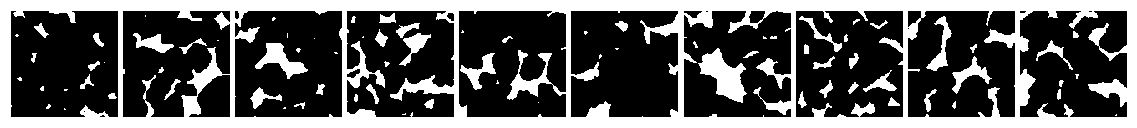

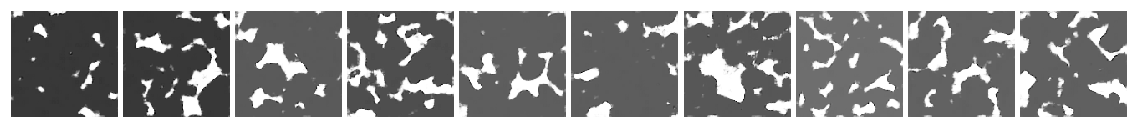

In [133]:
%matplotlib inline
def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

X_mb = images[0:mb_size]
recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                 label:Y_L.reshape(mb_size,1)})
plot(images[10:20])
plot(recon[10:20])

(array([   6.,   27.,   68.,  142.,  193.,  123.,   63.,   13.,    4.,    1.]),
 array([-1.86418092, -1.44489311, -1.0256053 , -0.60631748, -0.18702967,
         0.23225814,  0.65154595,  1.07083377,  1.49012158,  1.90940939,
         2.3286972 ]),
 <a list of 10 Patch objects>)

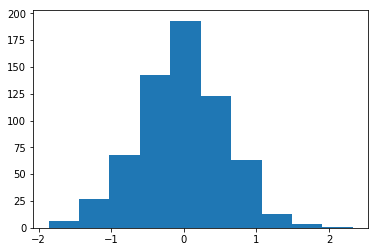

In [15]:
X_mb = images[0:20]
latent_z = sess.run(z_sample,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1)})
plt.hist(latent_z.reshape(-1))

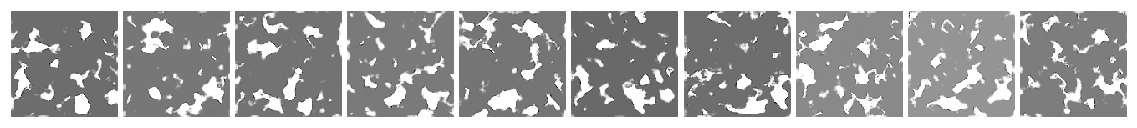

In [134]:
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
plot(samples[0:10])

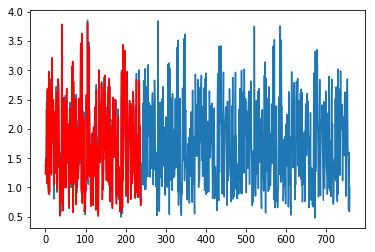

In [124]:
Y_pred_store_temp=[]
for it in range(760/mb_size):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    Y_pred = sess.run(pred, feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1)})
    Y_pred_store_temp.append(Y_pred)
Y_pred_store=[]
for i in range(38):
    for j in range(20):
        Y_pred_store.append(Y_pred_store_temp[i][j])
plt.plot(Y_pred_store)
plt.plot(images_L,'red')

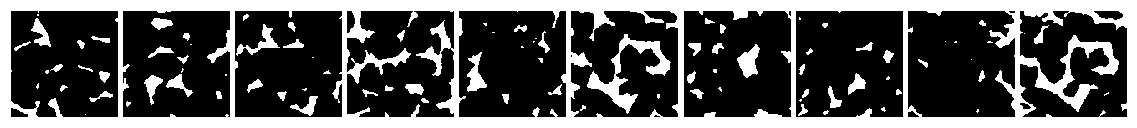

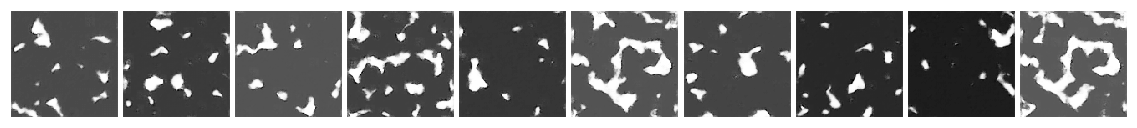

In [31]:
# =============================== Validation ====================================
images_test = np.array(sio.loadmat('alloy_mat/sandstone_v2_test.mat')['Data'],dtype='float32')
images_L_test = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young_test.mat')['L'],dtype='float32')

X_mb_test=images_test[0:mb_size]
z_temp=sess.run(z_mu, feed_dict={X:X_mb_test.reshape(mb_size, width, height, num_channels_1)})
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(X_mb_test[0:10])
plot(sample_temp[0:10])

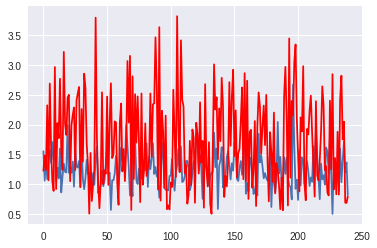

In [135]:
Y_pred_store_temp=[]
for it in range(240/mb_size):
    X_mb = images_test[(it*mb_size)%240:(it*mb_size)%240+mb_size]
    Y_pred = sess.run(pred, feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1)})
    Y_pred_store_temp.append(Y_pred)
Y_pred_store=[]
for i in range(240/20):
    for j in range(20):
        Y_pred_store.append(Y_pred_store_temp[i][j])
plt.plot(Y_pred_store)
plt.plot(images_L_test,'red')   

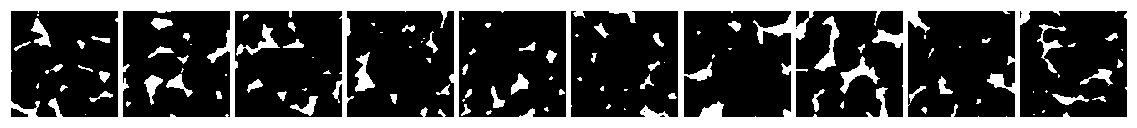

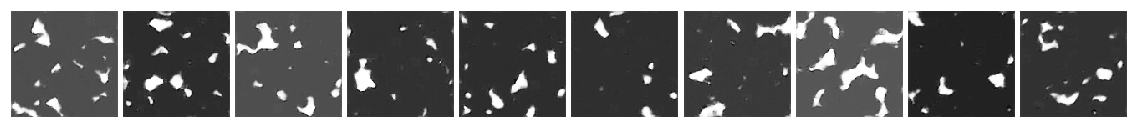

In [32]:
# =============================== Validation ====================================
images_diff = np.array(sio.loadmat('alloy_mat/diff_fig.mat')['img'],dtype='float32')


X_mb = images_diff[0:mb_size]
recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1)})
plot(images_diff[0:10])
plot(recon[0:10])


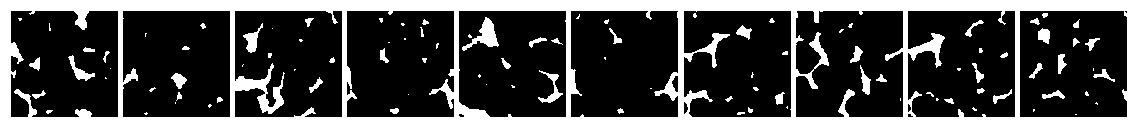

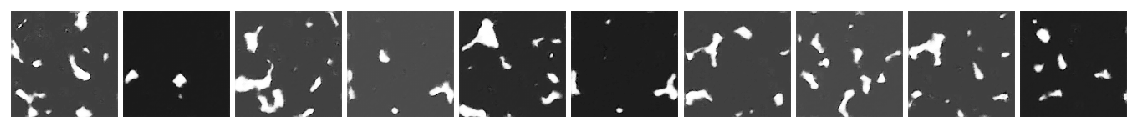

In [70]:
X_mb = images_diff[0:mb_size]
# recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
#                                  label:Y_L.reshape(mb_size,1)})

z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, num_channels_1)})
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})

plot(X_mb[10:20])
plot(sample_temp[10:20])

In [115]:
k*10+mb_size

120

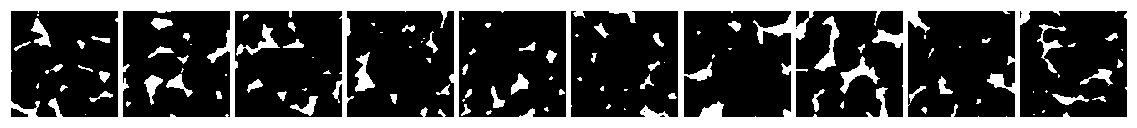

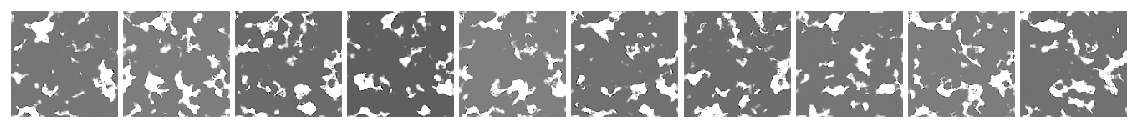

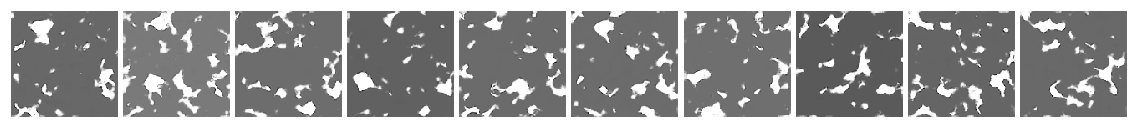

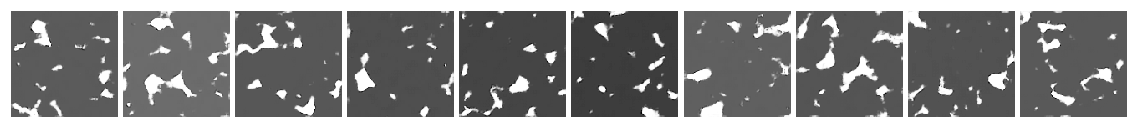

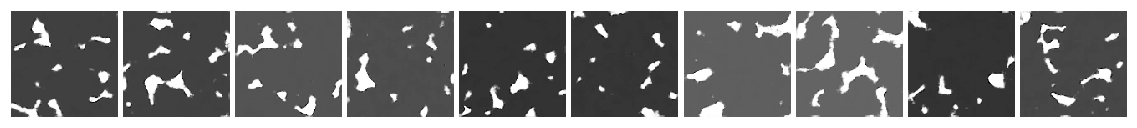

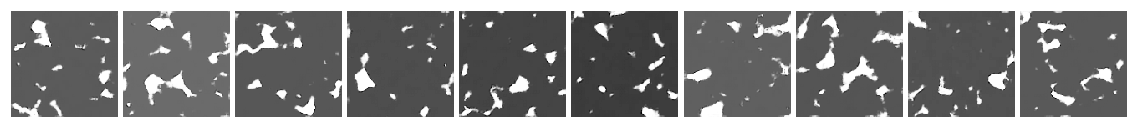

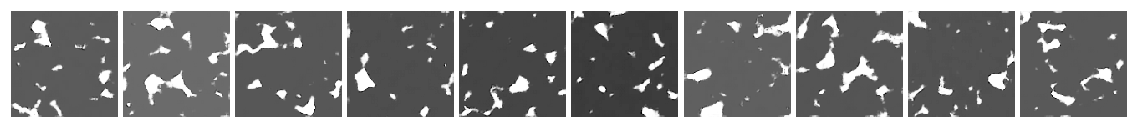

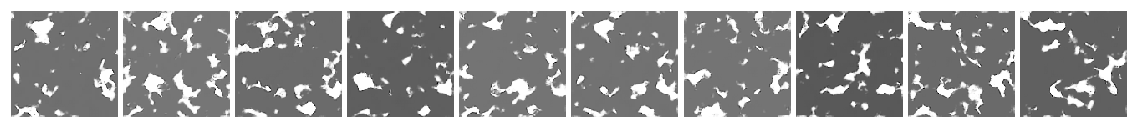

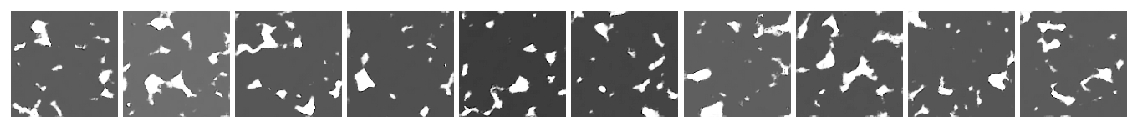

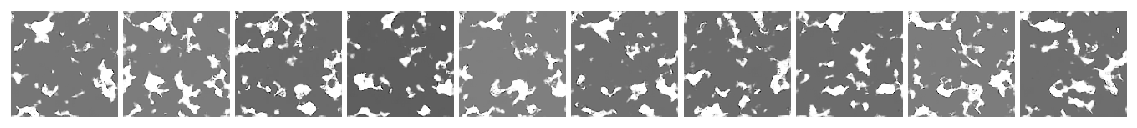

In [131]:
X_mb = images_diff[0:mb_size]
# recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
#                                  label:Y_L.reshape(mb_size,1)})

xtr=np.zeros([mb_size*10,width,height,num_channels_1])
k=0
for i in range(10):  
    z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, num_channels_1)})
    
    rand_index=random.sample(np.arange(32),32)
    z_temp[:,rand_index]=z_temp[:,rand_index]+random.random()    
    
    sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
    xtr[k*mb_size:k*mb_size+mb_size,:,:,:]=sample_temp
    k=k+1
    
plot(X_mb[0:10])
plot(xtr[0:10])
plot(xtr[20:30])
plot(xtr[40:50])
plot(xtr[60:70])
plot(xtr[80:90])
plot(xtr[100:110])
plot(xtr[120:130])
plot(xtr[140:150])
plot(xtr[160:170])

In [108]:
xtr.shape

(200, 128, 128, 1)

In [103]:
sample_temp.shape

(20, 128, 128, 1)

In [73]:
import random
# noise=np.zeros([20,32])
# np.random.permutation(16)
rand_index=random.sample(np.arange(32),8)
z_temp[:,rand_index]=z_temp[:,rand_index]+random.random()

In [102]:
random.random()

0.661602944971148

In [61]:
np.arange(10).tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]